Installing/Importing requirements

In [ ]:
!sudo update-alternatives --install /usr/bin/python python /usr/local/lib/python3.6 1
!sudo update-alternatives --config python3
!sudo update-alternatives --config python
!sudo update-alternatives  --set python /usr/local/lib/python3.6

update-alternatives: using /usr/local/lib/python3.6 to provide /usr/bin/python (python) in auto mode
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.7   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode
There is only one alternative in link group python (providing /usr/bin/python): /usr/local/lib/python3.6
Nothing to configure.


In [ ]:
!wget https://bootstrap.pypa.io/get-pip.py
!sudo python3.6 get-pip.py

--2021-07-25 11:24:49--  https://bootstrap.pypa.io/get-pip.py
Resolving bootstrap.pypa.io (bootstrap.pypa.io)... 151.101.0.175, 151.101.64.175, 151.101.128.175, ...
Connecting to bootstrap.pypa.io (bootstrap.pypa.io)|151.101.0.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1937837 (1.8M) [text/x-python]
Saving to: ‘get-pip.py’

get-pip.py          100%[===================>]   1.85M  --.-KB/s    in 0.06s   

2021-07-25 11:24:49 (33.0 MB/s) - ‘get-pip.py’ saved [1937837/1937837]

     |████████████████████████████████| 1.6 MB 9.6 MB/s 
     |████████████████████████████████| 819 kB 55.9 MB/s 


In [ ]:
!pip --version
!python --version

import sys

sys.path[2] = '/usr/lib/python36.zip'
sys.path[3] = '/usr/lib/python3.6'
sys.path[4] = '/usr/lib/python3.6/lib-dynload'
sys.path[5] = '/usr/local/lib/python3.6/dist-packages'
sys.path[7] ='/usr/local/lib/python3.6/dist-packages/IPython/extensions'

pip 21.2.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Python 3.6.9


In [ ]:
!pip install transformers
#!pip install torch
#!pip uninstall Cython

     |████████████████████████████████| 2.6 MB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 65.2 MB/s 
     |████████████████████████████████| 895 kB 62.3 MB/s 
     |████████████████████████████████| 636 kB 29.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from tqdm.autonotebook import tqdm

##Preprocessing

In [ ]:
def preprocess(bs: BeautifulSoup) -> List[dict]:

    data = []

    for s in bs.find_all("sentence"):
        sid = s.get("id")
        s1 = s.find_all("text")[0].contents[0]

        records = []

        categories = ["food", "service", "price", "ambience", "anecdotes"]

        labels = {c: "none" for c in categories}

        for ac in s.find_all("aspectcategory"):
            category = ac.get("category")
            polarity = ac.get("polarity")

            if category.startswith("anecdotes"):
                category = "anecdotes"

            labels[category] = polarity

        records = 5*[None]
        for i, (c, label) in enumerate(labels.items()):
            data += [{
                "sentence_id": sid,
                "s1": s1,
                "s2": c,
                "label": label
            }]

    return data


def load_data(model_name: str):
    base_url = "https://raw.githubusercontent.com/mwbrulhardt/yelp-absa/main/data/semeval2014"
    bs_train = BeautifulSoup(requests.get(base_url + "/Restaurants_Train.xml").content)
    bs_test = BeautifulSoup(requests.get(base_url + "/Restaurants_Test_Gold.xml").content)
    
    frames = {
        "train": pd.DataFrame(preprocess(bs_train)),
        "test": pd.DataFrame(preprocess(bs_test))
    }

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    labels = ["none", "negative", "neutral", "positive", "conflict"]
    label_map = {label: i for (i, label) in enumerate(labels)}

    datasets = {
        "train": None,
        "test": None
    }

    for k in datasets:
        data = frames[k]
        labels = list(data.label.apply(lambda x: label_map[x]))

        encoded = tokenizer(
            list(data.s1),
            list(data.s2),
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        datasets[k] = torch.utils.data.TensorDataset(
            encoded["input_ids"],
            encoded["attention_mask"],
            torch.tensor(labels, dtype=torch.long).reshape(-1, 1)
        )

    return datasets["train"], datasets["test"]

## Training


In [ ]:
def acc(confusion: np.array) -> float:
    return confusion.trace() / confusion.sum().sum()


def mcc(confusion: np.array) -> float:
    t = confusion.sum(0)
    p = confusion.sum(1)
    c = confusion.trace()
    s = confusion.sum().sum()

    num = c*s - t.dot(p)
    den = np.sqrt(s**2 - p.dot(p))*np.sqrt(s**2 - t.dot(t))

    return num / den


def train_absa(config: dict):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_id = config["model_id"]

    num_labels = len(config["labels"])
    numeric_labels = list(range(num_labels))

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)
    model.train()
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=config["lr"]
    )

    train_set, test_set = load_data(model_id)

    cutoff = int(0.8 * len(train_set))
    train_subset, val_subset = random_split(train_set, [cutoff, len(train_set) - cutoff])

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )

    # Train
    total = (cutoff // config["batch_size"]) + int(cutoff % config["batch_size"] != 0)

    for epoch in range(config["epochs"]):

        for i, (input_ids, attention_mask, labels) in tqdm(enumerate(train_loader), total=total):
          
            optimizer.zero_grad()

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            loss = output["loss"]

            loss.backward()
            optimizer.step()

        # Validation
        running_loss = 0.0
        steps = 0
        confusion = np.zeros([num_labels, num_labels])

        for i, (input_ids, attention_mask, labels) in enumerate(val_loader):

            with torch.no_grad():

                output = model(
                    input_ids=input_ids.to(device),
                    attention_mask=attention_mask.to(device),
                    labels=labels.to(device)
                )
                loss, logits = output["loss"], output["logits"]

                confusion += confusion_matrix(
                    y_true=labels.flatten().cpu(), 
                    y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                    labels=numeric_labels
                )

                running_loss += loss.cpu().numpy()
                steps += 1

        summary = dict(
            loss=(running_loss / steps),
            accuracy=acc(confusion),
            mcc=mcc(confusion)
        )
        print(summary)


    torch.save(model, f"./absa-{model_id.replace('/', '_')}.pt")
    print("Finished training.")

    return model

In [ ]:
configs = [
    {
        "model_id": "prajjwal1/bert-tiny",
        "model_name": "bert-tiny",
        "epochs": 15,
        "batch_size": 24,
        "lr": 2e-5
    },
    {
        "model_id": "prajjwal1/bert-small",
        "model_name": "bert-small",
        "epochs": 10,
        "batch_size": 24,
        "lr": 2e-5
    },
    {
        "model_id": "distilbert-base-uncased",
        "model_name": "distilbert",
        "epochs": 4,
        "batch_size": 24,
        "lr": 2e-5
    },
    {
        "model_id": "bert-base-uncased",
        "model_name": "bert",
        "epochs": 4,
        "batch_size": 24,
        "lr": 2e-5
    }
]

config = configs[2]
config["labels"] = list(range(5))

In [ ]:
model = train_absa(config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier


{'loss': 0.4116829894776419, 'accuracy': 0.8590670170827858, 'mcc': 0.6341915486831787}



{'loss': 0.35695602592286163, 'accuracy': 0.8781208935611038, 'mcc': 0.6851145749839833}



{'loss': 0.34456066618578174, 'accuracy': 0.8889618922470434, 'mcc': 0.7055642967857961}



{'loss': 0.38172351522737835, 'accuracy': 0.8909329829172142, 'mcc': 0.7187836225195966}
Finished training.


## Evaluate

In [ ]:
def evaluate(model, ds, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels = len(config["labels"])
    numeric_labels = list(range(num_labels))

    test_loader = torch.utils.data.DataLoader(
        ds,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )
    model.eval()

    test_loss = 0
    test_steps = 0
    confusion = np.zeros([num_labels, num_labels])

    for i, (input_ids, attention_mask, labels) in enumerate(test_loader):

        with torch.no_grad():

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            loss, logits = output["loss"], output["logits"]

            confusion += confusion_matrix(
                y_true=labels.flatten().cpu(), 
                y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                labels=numeric_labels
            )

            test_loss += loss.cpu().numpy()
            test_steps += 1

    print("Test Results:")
    summary = dict(
        model=config["model_name"],
        loss=(test_loss / test_steps),
        accuracy=acc(confusion),
        mcc=mcc(confusion)
    )
    print(summary)

    return summary, confusion

In [ ]:
model = torch.load(f"absa-{config['model_id'].replace('/', '_')}.pt")
train_set, test_set = load_data(config["model_id"])

summary, confusion = evaluate(model, test_set, config)

Test Results:
{'model': 'distilbert', 'loss': 0.3364177213878577, 'accuracy': 0.90575, 'mcc': 0.7679568185010651}


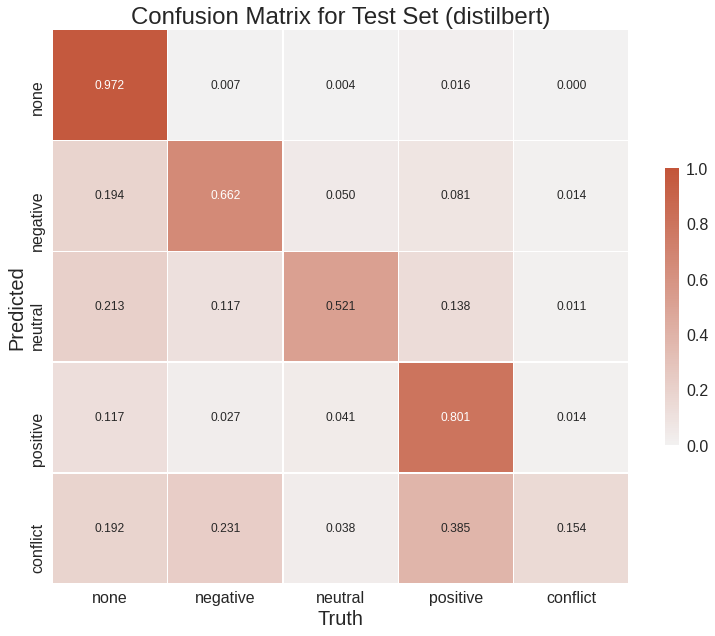

In [ ]:
sns.set_theme(style="white")
plt.style.use("seaborn")
plt.rcParams.update({
    "figure.titlesize": 30,
    "axes.titlesize": 24,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.title_fontsize": 20,
    "legend.fontsize": 16
})

labels = ["none", "negative", "neutral", "positive", "conflict"]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

X = confusion / confusion.sum(1, keepdims=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    pd.DataFrame(X, index=labels, columns=labels), 
    cmap=cmap, 
    center=0,
    vmin=0,
    vmax=1,
    annot=True, 
    fmt=".3f",
    linewidths=.5, 
    cbar_kws={
        "shrink": .5
    }
)
ax.set_title("Confusion Matrix for Test Set (distilbert)")
ax.set_xlabel("Truth")
ax.set_ylabel("Predicted")
plt.tight_layout()
plt.show()

##Testing Sample Data

In [ ]:
class SentimentAnalyzer:

    def __init__(self, model, model_name):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.aspects = ["food", "service", "price", "ambience", "anecdotes"]
        self.labels = ["none", "negative", "neutral", "positive", "conflict"]

    def __call__(self, text: str) -> dict:

        encoded = self.tokenizer(
            5*[text],
            self.aspects,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        with torch.no_grad():
            input_ids = encoded["input_ids"].to(self.device)
            attention_mask = encoded["attention_mask"].to(self.device)

            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = output["logits"]

            predicted = torch.softmax(logits, -1).argmax(-1)
            y_pred = predicted.cpu()

        return {a: self.labels[y_pred[i]] for i, a in enumerate(self.aspects)}

absa = SentimentAnalyzer(model, config["model_id"])

In [ ]:
samples = [
    "We had a good time at the restaurant.",
    "We had a good time at the restaurant. The food was delicious.",
    "The waiter we had was horrible, but the food was amazing.",
    "My girlfriend is still not even speaking to me after I took her on a date here last week. The food here was disgusting and the service was even worse. I will never in my life go back to this pizzeria.",
    "My girlfriend is still not even speaking to me after I took her on a date here last week. The atmosphere was nice, but the food here was disgusting and the service was even worse. I will never in my life go back to this pizzeria.",
    "My girlfriend is still not even speaking to me after I took her on a date here last week. Nevermind how expensive it was, the food was horrible and staff was very rude. The only redeeming quality was that the atmosphere was nice, however, I will never in my life go back to this pizzeria.",
    "Nevermind how expensive it was, the food was horrible and staff was very rude."
]

pd.DataFrame([absa(s) for s in samples])

,food,service,price,ambience,anecdotes
0,none,none,none,none,positive
1,positive,none,none,none,none
2,positive,negative,none,none,none
3,negative,negative,none,none,none
4,negative,negative,none,positive,none
5,negative,negative,none,positive,none
6,negative,negative,negative,none,none


##Setting up Pyspark for processing Yelp data

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 68 kB/s 
     |████████████████████████████████| 198 kB 65.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=020a10d9db60f9c2ab2409877b6fcdb1670f6dc0fd921b4b7be128377d16d6a3
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
import sys

sys.path[2] = '/usr/lib/python36.zip'
sys.path[3] = '/usr/lib/python3.6'
sys.path[4] = '/usr/lib/python3.6/lib-dynload'
sys.path[5] = '/usr/local/lib/python3.6/dist-packages'
sys.path[7] ='/usr/local/lib/python3.6/dist-packages/IPython/extensions'

In [ ]:
import json
import os
import zipfile
from datetime import datetime
from itertools import zip_longest

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

In [ ]:
from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

data_path = "data/yelp"

api.dataset_download_files(
    dataset="yelp-dataset/yelp-dataset",
    path=data_path
)

zip_path = os.path.join(data_path, "yelp-dataset.zip")
with zipfile.ZipFile(zip_path, "r") as zp:
    zp.extractall(data_path)
os.remove(zip_path)

prefix = "yelp_academic_dataset_"

for name in os.listdir(data_path):
    src = os.path.join(data_path, name)
    tgt = os.path.join(data_path, name.replace(prefix, ""))
    os.rename(src, tgt)

## Run

In [ ]:
def create_pairs(ds):
    while True:

        item = next(ds)

        for aspect in ["food", "service", "price", "ambience", "anecdotes"]:
            yield {
                "business_id": item["business_id"],
                "user_id": item["user_id"],
                "s1": item["text"],
                "s2": aspect
            }


def chunk(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)


def run(path: str, config: dict):
    start = datetime.utcnow()

    batch_size = config["batch_size"]

    device = torch.device("cuda")

    model_id = config["model_id"] 

    model = torch.load(f"absa-{model_id.replace('/', '-')}.pt")
    model.eval()

    tokenizer = AutoTokenizer.from_pretrained(model_id)

    print("Preprocessing...", datetime.utcnow())

    spark = SparkSession \
        .builder \
        .appName("ASBA") \
        .config("spark.driver.memory", "15g") \
        .config("spark.sql.shuffle.partitions", "300") \
        .getOrCreate()

    businesses = spark.read.json("data/yelp/business.json")
    tips = spark.read.json("data/yelp/tip.json")

    window_spec = Window.partitionBy("a.business_id")

    df =  tips.alias("a") \
      .join(businesses.alias("b"), tips.business_id == businesses.business_id, how="left") \
      .withColumn("tip_count", F.count("a.business_id").over(window_spec)) \
      .where(F.col("tip_count") >= 50) \
      .where((F.col("is_open") == 1) & (F.col("categories").contains("Restaurants"))) \
      .select("a.business_id", "user_id", "text")

    ds = df.toLocalIterator()
    ds = map(lambda x: x.asDict(), ds)
    ds = create_pairs(ds)
    ds = chunk(ds, batch_size)
    ds = map(lambda x: [item for item in x if item], ds)
    ds = map(lambda x: {k: [d[k] for d in x] for k in x[0]}, ds)

    print("Starting work...", datetime.utcnow())

    n = 5*df.count()
    total = n // batch_size + int(n % batch_size != 0)

    with open(path, "w+") as fp:
        for batch in tqdm(ds, total=total):

            encoded = tokenizer(
                batch["s1"],
                batch["s2"],
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=512
            )

            with torch.no_grad():
                output = model(
                    input_ids=encoded["input_ids"].to(device),
                    attention_mask=encoded["attention_mask"].to(device)
                )
                logits = output["logits"]

            p = torch.softmax(logits, -1)
            y_pred = p.argmax(-1)
            y_pred = y_pred.detach().cpu().numpy()

            p = p.detach().cpu().numpy()
            w = np.array([0, -1, 0, 1, 0]).reshape(-1, 1)

            polarity = (p@w).flatten()

            result = (batch["business_id"], batch["user_id"], batch["s2"], y_pred, polarity)

            for bid, uid, aspect, label, polarity in zip(*result):
                record = {
                    "business_id": bid,
                    "user_id": uid,
                    "aspect": aspect,
                    "label": int(label),
                    "polarity": polarity
                }
                line = json.dumps(record) + "\n"
                fp.write(line)

    print("Work complete.", datetime.utcnow())
    print("Duration:", datetime.utcnow() - start)

run(
    path="aspects.json",
    config={
        "model_id": "distilbert-base-uncased",
        "batch_size": 15
    }
)

Preprocessing... 2021-07-25 11:53:39.155380
Starting work... 2021-07-25 11:54:06.301675


## Results

In [ ]:
spark = SparkSession \
    .builder \
    .appName("ASBA") \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()

businesses = spark.read.json("data/yelp/business.json")
reviews = spark.read.json("data/yelp/review.json")
users = spark.read.json("data/yelp/user.json")
aspects = spark.read.json("aspects.json")

In [ ]:
adjusted = reviews \
    .join(users, reviews.user_id == users.user_id) \
    .withColumn("adjusted_stars", (1 / 2)*(F.col("stars") - F.col("average_stars")) + 3) \
    .select("business_id", "stars", "adjusted_stars") \
    .groupBy("business_id") \
    .mean()

bdf = businesses.alias("a") \
    .join(adjusted.alias("b"), businesses.business_id == adjusted.business_id) \
    .select("a.business_id", "name", "city", "state", "stars", "review_count", F.col("avg(adjusted_stars)").alias("adjusted_stars", )) \
    .toPandas()
bdf = bdf.set_index("business_id")


aspects = aspects.select("business_id", "user_id", "aspect", "polarity").groupBy(["business_id"]).pivot("aspect").mean()
aspects = aspects.toPandas()
aspects = aspects.set_index("business_id")
aspects = 2*aspects + 3

results = pd.concat([bdf, aspects], join="inner", axis=1)
results = results.rename({"adjusted_stars": "overall"}, axis=1)

In [ ]:
w = np.array([7, 9, 10, 5, 5, 2])
w = w / w.sum()

R = results.get(["overall", "food", "service", "price", "ambience", "anecdotes"])

results["score"] = R.values@w
results = results.sort_values("score", ascending=False)

In [ ]:
!pip install https://ray-wheels.s3-us-west-2.amazonaws.com/master/{COMMIT_HASH}/ray-{RAY_VERSION}-{PYTHON_VERSION}-{PYTHON_VERSION}m-{OS_VERSION}_intel.whl